### <center>**Reading and Cleaning Annotation Data for Custom PyTorch Object Detection**</center> 

In [1]:
# Import necessary packages
%matplotlib inline
import json
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion(); # interactive mode

##### Helper Functions for Processing JSONs

In [2]:
# Function for reading JSON as dictionary
def read_json(filename: str) -> dict:
  
    try:
        with open(filename, "r") as f:
            data = json.loads(f.read())
    except:
        raise Exception(f"Reading {filename} file encountered an error")
  
    return data

# Function to append records to df
def create_dataframe(data: list) -> pd.DataFrame:

    # Create an empty dataframe to append records
    df = pd.DataFrame()
  
    # Looping through each record
    for d in data:
          
        # Normalize the column levels
        record = pd.json_normalize(d)

        df = pd.concat([df, record], axis=0)
          
    return df

# Main function to iterate over files in directory and add to df
def main():
    # Assign directory and empty df for appending annotations
    directory = "E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations" # annotation directory
    annos_df = pd.DataFrame()
    
    # Iterate over files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
            
        # Read the JSON file as python dictionary 
        data = read_json(filename = f)
    
        # Create the dataframe for the array items in annotations key 
        df = create_dataframe(data = data['annotations'])
        df.insert(loc = 0, column = 'img_name', value = f'{f[-30:-5]}.JPG')
    
        df.rename(columns = {
            "img_name": "img_name",
            "name": "label",
            "bounding_box.h": "bbox_height",
            "bounding_box.w": "bbox_width",
            "bounding_box.x": "bbox_x_topLeft",
            "bounding_box.y": "bbox_y_topLeft",
            "polygon.paths": "polygon_path"
        }, inplace = True)
        
        # Append the df dataframe to the annos_df dataframe
        annos_df = pd.concat([annos_df, df], ignore_index=True)

    # Convert x, y, h, w to xmin, ymin, xmax, ymax
    annos_df.insert(loc = 2, column = 'xmin', 
                    value = annos_df['bbox_x_topLeft'])
    annos_df.insert(loc = 3, column = 'ymin', 
                    value = annos_df['bbox_y_topLeft'])
    annos_df.insert(loc = 4, column = 'xmax', 
                    value = annos_df['bbox_x_topLeft'] + annos_df['bbox_width'])
    annos_df.insert(loc = 5, column = 'ymax', 
                    value = annos_df['bbox_y_topLeft'] + annos_df['bbox_height']) 
  
    # Drop unneccessary columns 
    annos_df = annos_df.drop(columns = ['bbox_height', 'bbox_width', 'bbox_x_topLeft', 
                                        'bbox_y_topLeft', 'id', 'slot_names', 'polygon_path'])
        
    return annos_df

##### Load Annotation Data into Dataframe

In [3]:
# Execute main function
if __name__ == '__main__':
    df = main()

E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\DJI_20230108133602_0033_Z.json
E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\DJI_20211215103949_0003_Z.json
E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\DJI_20211215103957_0004_Z.json
E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\DJI_20211215105707_0002_Z.json
E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\DJI_20211215105716_0003_Z.json
E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\DJI_20211215105736_0004_Z.json
E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\DJI_20211215105752_0005_Z.json
E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\DJI_20211215105813_0006_Z.json
E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\DJI_20211215105821_0007_Z.json
E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Annotations\D

##### Filter Annotation Dataframe

In [4]:
# If label value count is less than 200, drop the row
df = df.groupby('label').filter(lambda x : len(x) > 200)

# If label value is 'Hen', drop the row
df = df[df['label'] != 'Hen']

##### Filter images without filtered annotations

In [5]:
# # Store unique img_names in filtered df as array
# img_names = df['img_name'].unique().tolist()

# # Create a new directory called 'filtered_images'
# new_dir = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images'
# if not os.path.exists(new_dir):
#     os.makedirs(new_dir)

# # Copy images in img_names to new directory
# for img in img_names:
#     shutil.copy2(f'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/Images/{img}', new_dir)

### <center>**Transform and Augment Image and Annotation Data for Custom PyTorch Object Detection**</center> 

In [6]:
# import necessary packages
import numpy as np
from skimage import io
from collections import defaultdict
import torch
from torch.utils.data import Dataset
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.io import read_image
from torchvision import datapoints as dp
import torchvision.transforms.v2 as T
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import utils

##### Pre-process Annotation Data

In [7]:
# use ordinal encoder to convert df['label'] to numeric values. 0 is reserved for background class.
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
df.insert(loc = 6, column = 'target', value = (oe.fit_transform(df[['label']])) + 1)

# Create a dictionary using df['label'] as the keys and df['label_code'] as the values
label_dict = dict(zip(df['target'], df['label']))

# Drop label column from df
df = df.drop(['label'], axis = 1)

# Change target column name to label
df.rename(columns = {'target': 'label'}, inplace = True)

# Save df as csv in directory
df.to_csv('E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_annotations.csv', index = False)

##### PyTorch Dataset for Custom Image and Annotation Data

In [8]:
# Custom dataset loader (PyTorch) for loading images and annotation data
class MAVdroneDataset(Dataset):
    """Dataset Loader for Waterfowl Drone Imagery"""

    def __init__(self, csv_file, root_dir, transforms):
        """
        Arguments:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory containing all images.
            transforms (string): train = True for training transforms
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir

        self.transforms = transforms


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = read_image(image_path)

        boxes = self.df[self.df['img_name'] == self.df.iloc[idx, 0]][['xmin', 'ymin', 'xmax', 'ymax']].values 
        labels = self.df[self.df['img_name'] == self.df.iloc[idx, 0]]['label'].values

        labels = torch.as_tensor(labels, dtype = torch.int64) # (n_objects)

        boxes = torch.as_tensor(boxes, dtype = torch.float32)

        # if xmin > xmax, flip them so width is always positive
        if torch.any(boxes[:, 0] > boxes[:, 2]):
            boxes[:, [0, 2]] = boxes[:, [2, 0]]
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
            
        target = {}
        target['boxes'] = dp.BoundingBox(boxes, format = "XYXY", spatial_size = (image.shape[1], image.shape[2]))
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        image = dp.Image(image)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self):
        return len(self.df['img_name'].unique())

##### Data Transformation Function

In [9]:
# ImageNet mean and std since using pretrained VGG16 backbone
mean = [0.485, 0.456, 0.406] # 3 bands
std = [0.229, 0.224, 0.225]

# Same transforms as original SSD paper
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomZoomOut(fill = defaultdict(lambda: 0, {dp.Image: (255, 20, 147)}),
                                          p = 0.3,
                                          side_range = (1.0, 2.0)))
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.Resize((300, 300), antialias = True)) # no maintain aspect ratio
        transforms.append(T.RandomHorizontalFlip(0.5))
    else:
        transforms.append(T.Resize((300, 300), antialias = True)) # no maintain aspect ratio
    transforms.append(T.ToImageTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    transforms.append(T.SanitizeBoundingBox())
    transforms.append(T.Normalize(mean, std)) # ImageNet mean and std values for normalization
    return T.Compose(transforms)

##### Helper Functions for Plotting Image and Annotations

In [10]:
# classes are values in label_dict
classes = list(label_dict.values())

# reverse label dictionary for mapping predictions to classes
rev_label_dict = {v: k for k, v in label_dict.items()}

# distinct colors 
distinct_colors = ['#f032e6', '#ffffff', '#ffe119', '#3cb44b', '#42d4f4',
                    '#f58231', '#e6194B', '#dcbeff', '#469990', '#4363d8']

# label color map for plotting color-coded boxes by class
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes, image):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax
 

def plot_bbox(image, ax, boxes, labels):
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    # add label text to bounding box using label_dict if label exists else labels
    ax.text(boxes[:, 2], boxes[:, 3], 
            (label_dict[labels.item()] if labels.item() in label_dict else labels.item()),
            fontsize = 8,
            bbox = dict(facecolor = 'white', alpha = 0.8, pad = 0, edgecolor = 'none'),
            color = 'black')


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_detections(image, boxes, labels, ax = None):
    ax = img_show(image.permute(1, 2, 0), ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i], image)
        plot_bbox(image, ax, box, labels[i])

##### Plot Sample Batch for Visual Confirmation Data Loads Correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


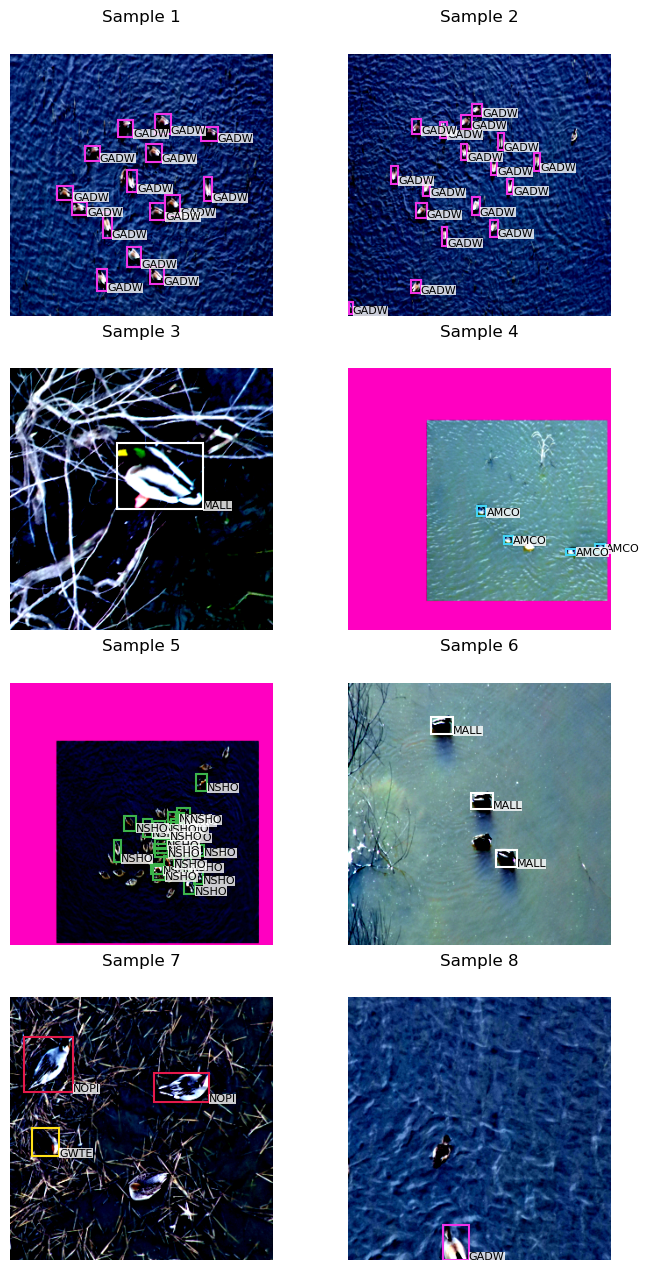

In [11]:
# Load sample batch of filtered annotations and images to custom PyTorch Dataset and Transform
sample_dataset = MAVdroneDataset(csv_file = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_annotations.csv', 
                                root_dir = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images', 
                                transforms = get_transform(train = True))

sample_data_loader = torch.utils.data.DataLoader(sample_dataset, batch_size = 8, shuffle = True, 
                                             collate_fn = utils.collate_fn, num_workers = 0)

# store images and annotation targets from sample batch
images, targets = next(iter(sample_data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# Plot the all samples from batch in a grid of subplots. 
plt.figure(figsize = (8, 32))
for i in range(8):
    ax = plt.subplot(8, 2, 1 + i)
    plot_detections(images[i], targets[i]['boxes'], targets[i]['labels'], ax = ax)
    plt.axis('off')
    plt.title(f"Sample {i + 1}")

plt.show()

### <center>**Tuning Model Hyperparameters using Ray Tune**</center> 

In [ ]:
# import necessary packages
import ray
from ray import tune
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.schedulers import ASHAScheduler
from ray.air import session
from functools import partial
from datetime import datetime
from engine_gradientAccumulation import train_one_epoch, evaluate

##### Initialize Ray Instance

In [ ]:
ray.init() 

##### Helper Functions for Hyperparameter Tuning

In [ ]:
# Wrap data loaders in function and pass global data directories. 
def load_data(csv_file = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_annotations.csv', 
              root_dir = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images/'):

    # use MAVdroneDataset and defined transformations
    dataset = MAVdroneDataset(csv_file = csv_file,
                                root_dir = root_dir, 
                                transforms = get_transform(train = True))
    
    dataset_val = MAVdroneDataset(csv_file = csv_file,
                                root_dir = root_dir, 
                                transforms = get_transform(train = False))
    
    return dataset, dataset_val


# Main function that performs training and validation. 
def tune_MAVdroneDataset(config, csv_file = None, root_dir = None):

    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Initialize model--SSD300 w/ VGG16 backbone
    model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
                        weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')
    
    model.to(device) # move model to the right device
    
    # construct an optimizer 
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr = config["lr"],
                                momentum = config["momentum"], 
                                weight_decay = config["weight_decay"])
    
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size = config["step_size"], # period of lr decay
                                                   gamma = config["gamma"]) # multiplicative factor of lr decay

    # load checkpoint if available
    checkpoint = session.get_checkpoint()

    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        model.load_state_dict(checkpoint_state["model_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    # load train and val datasets
    dataset, dataset_val = load_data(csv_file, root_dir)
    
    # store indices in random order list
    indices = torch.randperm(len(dataset_val)).tolist()

    # subset using a 80/15/5 split for train, validation, and test datasets
    dataset = torch.utils.data.Subset(dataset, indices[:-int(len(dataset)*0.2)]) # first 80% of dataset

    dataset_val = torch.utils.data.Subset(dataset_val, indices[-int(len(dataset_val)*0.2):-int(len(dataset_val)*0.05)])

    # Lists for storing the training and validation loss and accuracy values
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    # Hyperparameter values for each training step; batch_size increases by a factor of 4 at each step
    # accumulation steps is N batches to accumulate gradients for before zeroing gradients
    training_steps = [
        {"step": 0, "batch_size": 4, "epochs": 1, "print_freq": 50, 'accumulation_steps': 1},
        {"step": 1, "batch_size": 16, "epochs": 1, "print_freq": 20, 'accumulation_steps': 1}, 
        # {"step": 2, "batch_size": 64, "epochs": 1, "print_freq": 10, 'accumulation_steps': 1}, # gpu memory maxes out at batch size 64 
        # {"step": 3, "batch_size": 64, "epochs": 1, "print_freq": 5, 'accumulation_steps': 4}, # accumulate gradients for four batches before zeroing
    ]

    # loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = step['batch_size']
        num_epochs = step['epochs']
        print_freq = step['print_freq']
        accumulation_steps = step['accumulation_steps']

        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, 
                                                collate_fn = utils.collate_fn, num_workers = 0,
                                                pin_memory = True)
        
        data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 1, shuffle = False,
                                                    collate_fn = utils.collate_fn, num_workers = 0,
                                                    pin_memory = True)

        print(f'Beginning training step {step["step"]}... batch size: {batch_size*accumulation_steps}')

        #########################################################
        ##               The main training loop                ##
        #########################################################
        for epoch in range(start_epoch, num_epochs + start_epoch):
            
            print()
            print(f'Epoch {epoch} beginning training...')
            print()
            
            # train for one epoch across N accumulation_steps; print every print_freq iterations
            train_one_epoch(model, optimizer, data_loader, accumulation_steps, device, epoch, print_freq)

            # send train images, targets to device
            images, targets = next(iter(data_loader))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # calculate bbox_regression and classification loss - normalize for batch accumulation
            train_bbox_loss = model(images, targets)['bbox_regression'].item() # L2-Norm
            train_class_loss = model(images, targets)['classification'].item() # Categorical cross entropy

            # total loss is sum of bbox regression and classification loss
            train_loss = train_bbox_loss + train_class_loss

            # append train_losses to lists
            training_loss.append(train_loss)

            # initialize MeanAveragePrecision metric
            train_metric = MeanAveragePrecision(iou_type = "bbox",
                                        class_metrics = True, 
                                        max_detection_thresholds = [1, 10, 100, 1000])
            
            # set model to eval mode
            model.eval()

            # calculate mAP and mAR from validation dataset
            train_metric.update(model(images, targets), targets)

            # append to list
            training_mean_AP = train_metric.compute()
            training_accuracy.append(float(training_mean_AP['map_50'].item()))

            # set model back to train mode
            model.train()

            # update the learning rate
            lr_scheduler.step()

            # send val images, targets to device
            images, targets = next(iter(data_loader_val))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            val_bbox_loss = model(images, targets)['bbox_regression'].item() # L2-Norm
            val_class_loss = model(images, targets)['classification'].item() # Categorical cross entropy

            # total loss is sum of bbox regression and classification loss
            val_loss = val_bbox_loss + val_class_loss

            # append val_loss to lists
            validation_loss.append(val_loss)

            # evaluate on the validation dataset(from engine_gradientAccumulation.py)
            evaluate(model, data_loader_val, device)

            # initialize MeanAveragePrecision metric
            val_metric = MeanAveragePrecision(iou_type = "bbox",
                                        class_metrics = True, 
                                        max_detection_thresholds = [1, 10, 100, 1000])
            
            # calculate mAP and mAR from validation dataset
            val_metric.update(model(images, targets), targets)

            # append to list
            val_mean_AP = val_metric.compute()
            validation_accuracy.append(float(val_mean_AP['map_50'].item()))

            print(f'Epoch {epoch} complete! Moving onto epoch {epoch + 1}...')
            print()

        # report session metrics for current training step
        session.report(
            {"loss": val_loss,
            "precision": val_mean_AP['map_50'].item(),
            "recall": val_mean_AP['mar_100'].item(),
            "epoch": epoch}
        )

        print(f'Training step {step["step"]} complete! Moving onto training step {step["step"] + 1}...')
        print()
        
        # set start_epoch to current epoch for next training step
        start_epoch = num_epochs if step['step'] == 0 else num_epochs + start_epoch        
    
    print('Tuning Trial Complete!')


# Main function for hyperparameter tuning
def main(num_trials, max_num_epochs, gpus_per_trial):
    
    csv_file = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_annotations.csv'
    root_dir = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images/'
    load_data(csv_file, root_dir)

    # configure your hyperparameter search space
    config = {
        "lr": (5e-6, 0.9),
        "momentum": (0.3, 1.0),
        "weight_decay": (5e-6, 0.1),
        "step_size": ([1, 30]),
        "gamma": (0.0, 0.9),
    }

    # intitialize scheduler and reporter
    scheduler = ASHAScheduler(
        metric = "precision", 
        mode = "max",
        max_t = max_num_epochs,
        grace_period = 1,
        reduction_factor = 2
    )

    # Bayesian Optimization search algorithm
    # https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.bayesopt.BayesOptSearch.html
    bayesopt = BayesOptSearch(
        space = config,
        metric = "precision",
        mode = "max",
        points_to_evaluate = [
            {"lr": 0.0005, "momentum": 0.9, "weight_decay": 0.0005, "step_size": 3, "gamma": 0.1} 
        ], # Default PyTorch hyperparameter values to begin search
        random_search_steps = 1
    )

    # run hyperparameter tuning
    result = tune.run(
        partial(tune_MAVdroneDataset, csv_file = csv_file, root_dir = root_dir),
        search_alg = bayesopt,
        resources_per_trial = {"cpu": 2, "gpu": gpus_per_trial},
        num_samples = num_trials,
        scheduler = scheduler,
    )

    # print best trial config
    best_trial = result.get_best_trial("precision", "max", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']:.4f}")
    print(f"Best trial final validation precision: {best_trial.last_result['precision']:.4f}")
    print(f"Best trial final validation recall: {best_trial.last_result['recall']:.4f}")

    # initialize SSD VGG16 pre-trainedd model
    model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
                        weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model.to(device)

    best_checkpoint_data = best_trial.checkpoint.to_dict()

    # save model weights to best checkpoint
    model.load_state_dict(best_checkpoint_data["model_state_dict"])

    # save model weights to .pth file
    torch.save(model.state_dict(), 'SSD_VG16_tuning_bestResult', + str(datetime.now().strftime("%Y%m%d")) + '.pth')

    return best_trial


# Execute main function for hyperparameter tuning
if __name__ == "__main__":
    best_trial = main(num_trials = 2, max_num_epochs = 20, gpus_per_trial = 1)

### <center>**Train Model Using Tuned Hyperparameters**</center> 

In [15]:
# modified engine.py training to accumulate for N batches before zeroing gradients
from datetime import datetime
from engine_gradientAccumulation import train_one_epoch, evaluate
from torch.utils.tensorboard import SummaryWriter

torch.cuda.empty_cache() 

# PyTorch Defaults for fine-tuning
learning_rate = 0.005
momentum = 0.9
weight_decay = 0.0005
step_size = 3
gamma = 0.1

# # Hyperparameter tuning results
# learning_rate = 0.01
# momentum = 0.757
# weight_decay = 0.005
# step_size = 21.85
# gamma = 0.393

# Hyperparameter values for each training step; batch_size increases by a factor of 4 at each step
# accumulation steps is N batches to accumulate gradients for before zeroing gradients
training_steps = [
    {"step": 0, "batch_size": 4, "lr": learning_rate, "epochs": 1, "print_freq": 75, 'accumulation_steps': 1}, 
    {"step": 1, "batch_size": 16, "lr": learning_rate, "epochs": 1, "print_freq": 20, 'accumulation_steps': 1}, # no gradient accumulation
    {"step": 2, "batch_size": 64, "lr": learning_rate, "epochs": 1, "print_freq": 5, 'accumulation_steps': 1}, # gpu memory maxes out at batch size 64
    {"step": 3, "batch_size": 64, "lr": learning_rate, "epochs": 1, "print_freq": 5, 'accumulation_steps': 4}, # batch size 256 via gradient accumulation
]

# Main function that performs training and validation. 
def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Initialize model--SSD300 w/ VGG16 backbone
    model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
                        weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')

    # move model to device
    model.to(device)

    # Lists for storing the training and validation loss and accuracy values
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    start_epoch = 0

    # initialize tensorboard writer
    writer = SummaryWriter()

    # loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = step['batch_size']
        lr = step['lr']
        num_epochs = step['epochs']
        print_freq = step['print_freq']
        accumulation_steps = step['accumulation_steps']

        # Log the hyperparameters to tensorboard
        writer.add_hparams(
            {"lr": learning_rate, "momentum": momentum, "weight_decay": weight_decay, "step_size": step_size, "gamma": gamma, "batch_size": (batch_size*accumulation_steps)},
            {}
        )
    
        # use MAVdroneDataset and defined transformations
        dataset = MAVdroneDataset(csv_file = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_annotations.csv',
                                root_dir = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images/', 
                                transforms = get_transform(train = True))
        
        dataset_val = MAVdroneDataset(csv_file = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_annotations.csv',
                                root_dir = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images/',
                                transforms = get_transform(train = False))
        
        # store indices in random order list
        indices = torch.randperm(len(dataset_val)).tolist()

        # subset using a 80/15/5 split for train, validation, and test datasets
        dataset = torch.utils.data.Subset(dataset, indices[:-int(len(dataset)*0.2)])

        dataset_val = torch.utils.data.Subset(dataset_val, indices[-int(len(dataset_val)*0.2):-int(len(dataset_val)*0.05)])

        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, 
                                                collate_fn = utils.collate_fn, num_workers = 0,
                                                pin_memory = True)
        
        data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 1, shuffle = False,
                                                    collate_fn = utils.collate_fn, num_workers = 0,
                                                    pin_memory = True)

        # construct an optimizer - SGD w/ momentum and weight decay
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr = lr,
                                    momentum = momentum, weight_decay = weight_decay)
    
        # and a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size = step_size,
                                                    gamma = gamma)

        print(f'Beginning training step {step["step"]}... batch size: {batch_size*accumulation_steps}')


        #########################################################
        ##               The main training loop                ##
        #########################################################
        for epoch in range(start_epoch, num_epochs + start_epoch):
            
            print()
            print(f'Epoch {epoch} beginning training...')
            print()
            
            # train for one epoch across N accumulation_steps; print every print_freq iterations
            train_one_epoch(model, optimizer, data_loader, accumulation_steps, device, epoch, print_freq)

            print()
            print(f'Epoch {epoch} finished training!')
            print()

            # send train images, targets to device
            images, targets = next(iter(data_loader))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # calculate bbox_regression and classification loss - normalize for batch accumulation
            train_bbox_loss = model(images, targets)['bbox_regression'].item() # L2-Norm
            train_class_loss = model(images, targets)['classification'].item() # Categorical cross entropy

            # total loss is sum of bbox regression and classification loss
            train_loss = train_bbox_loss + train_class_loss

            # append train_losses to lists
            training_loss.append(train_loss)

            # initialize MeanAveragePrecision metric
            metric = MeanAveragePrecision(iou_type = "bbox",
                                        class_metrics = True, 
                                        max_detection_thresholds = [1, 10, 100, 1000])
            
            # set model to eval mode
            model.eval()

            # calculate mAP and mAR from validation dataset
            metric.update(model(images, targets), targets)

            # append to list
            training_mean_AP = metric.compute()
            training_accuracy.append(float(training_mean_AP['map_50'].item()))

            # set model back to train mode
            model.train()

            # report training scalars to tensorboard
            writer.add_scalar('Loss/train', np.array(float(train_loss)), epoch)
            writer.add_scalar('Accuracy/train', np.array(float(training_mean_AP['map_50'].item())), epoch)

            # update the learning rate
            lr_scheduler.step()

            print(f'Epoch {epoch} preparing to evaluate the validation dataset...')
            print()

            # send val images, targets to device
            images, targets = next(iter(data_loader_val))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            val_bbox_loss = model(images, targets)['bbox_regression'].item() # L2-Norm
            val_class_loss = model(images, targets)['classification'].item() # Categorical cross entropy

            # total loss is sum of bbox regression and classification loss
            val_loss = val_bbox_loss + val_class_loss

            # append val_losses to lists
            validation_loss.append(val_loss)

            # evaluate on the validation dataset
            evaluate(model, data_loader_val, device)

            print()
            print(f'Epoch {epoch} finished evaluating the validation dataset!')
            print()

            # initialize MeanAveragePrecision metric
            metric = MeanAveragePrecision(iou_type = "bbox",
                                        class_metrics = True, 
                                        max_detection_thresholds = [1, 10, 100, 1000])
            
            # calculate mAP and mAR from validation dataset
            metric.update(model(images, targets), targets)

            # append to list
            val_mean_AP = metric.compute()
            validation_accuracy.append(float(val_mean_AP['map_50'].item()))
            
            # report validation scalars to tensorboard
            writer.add_scalar('Loss/val', np.array(float(val_loss)), epoch)
            writer.add_scalar('Accuracy/val', np.array(float(val_mean_AP['map_50'].item())), epoch)

            print(f'Epoch {epoch} complete! Saving model weights...')
            print()

            # save best model weights after each epoch
            torch.save(model.state_dict(), 'ssd300_vgg16_' + str(datetime.now().strftime("%Y%m%d")) + '.pth')
            
            print(f'Epoch {epoch} weights saved! Moving onto epoch {epoch + 1}...')
            print()

        print(f'Training step {step["step"]} complete! Moving onto training step {step["step"] + 1}...')
        print()
        
        # set start_epoch to current epoch for next training step
        start_epoch = num_epochs if step['step'] == 0 else num_epochs + start_epoch
            
    print('All Training Steps Complete!')
    
    # close tensorboard writer
    writer.close()

    return training_loss, training_accuracy, validation_loss, validation_accuracy, model, indices

if __name__ == "__main__":
    training_loss, training_accuracy, validation_loss, validation_accuracy, model, indices = main()

Beginning training step 0... batch size: 4

Epoch 0 beginning training...

Epoch: [0]  [  0/375]  eta: 0:05:01  lr: 0.000002  loss: 8.8258 (8.8258)  bbox_regression: 1.1177 (1.1177)  classification: 7.7080 (7.7080)  time: 0.8031  data: 0.6221  max mem: 5318
Epoch: [0]  [ 75/375]  eta: 0:03:39  lr: 0.000102  loss: 6.0298 (7.8251)  bbox_regression: 1.3595 (1.5201)  classification: 4.9511 (6.3051)  time: 0.7554  data: 0.6379  max mem: 5318
Epoch: [0]  [150/375]  eta: 0:03:11  lr: 0.000202  loss: 5.2922 (6.6715)  bbox_regression: 1.1962 (1.4449)  classification: 3.8628 (5.2265)  time: 0.9890  data: 0.8682  max mem: 5318
Epoch: [0]  [225/375]  eta: 0:02:10  lr: 0.000302  loss: 4.9851 (6.1825)  bbox_regression: 1.1132 (1.3867)  classification: 3.5435 (4.7958)  time: 0.9297  data: 0.8092  max mem: 5318
Epoch: [0]  [300/375]  eta: 0:01:05  lr: 0.000403  loss: 4.7768 (5.9426)  bbox_regression: 1.1991 (1.4112)  classification: 3.5102 (4.5314)  time: 0.9713  data: 0.8516  max mem: 5318
Epoch: [0]

In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# # Hyperparameters are best trial results from Bayesian Optimization using Ray Tune
# learning_rate = best_trial.config["lr"]
# momentum = best_trial.config["momentum"]
# weight_decay = best_trial.config["weight_decay"]
# step_size = best_trial.config["step_size"]
# gamma = best_trial.config["gamma"]

# # Results from Bayesian Optimization using Ray Tune
# learning_rate = 0.01
# momentum = 0.757
# weight_decay = 0.005
# step_size = 21.85
# gamma = 0.393

# # Hyperparameter values for each training step; batch_size increases by a factor of 4 at each step
# # accumulation steps is N batches to accumulate gradients for before zeroing gradients
# training_steps = [
#     {"step": 0, "batch_size": 4, "lr": learning_rate, "epochs": 5, "print_freq": 75, 'accumulation_steps': 1}, 
#     {"step": 1, "batch_size": 16, "lr": learning_rate, "epochs": 10, "print_freq": 25, 'accumulation_steps': 1}, # no gradient accumulation
#     {"step": 2, "batch_size": 64, "lr": learning_rate, "epochs": 10, "print_freq": 5, 'accumulation_steps': 1}, # gpu memory maxes out at batch size 32
#     {"step": 3, "batch_size": 64, "lr": learning_rate, "epochs": 5, "print_freq": 5, 'accumulation_steps': 4}, # batch size 256 via gradient accumulation
# ]

# torch.cuda.empty_cache() 

# # Main function that performs training and validation. 
# def main():
#     # train on the GPU or on the CPU, if a GPU is not available
#     device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#     # Initialize model--SSD300 w/ VGG16 backbone
#     model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
#                         weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')

#     # move model to device
#     model.to(device)

#     # Lists for storing the training and validation loss and accuracy values
#     training_loss = []
#     training_accuracy = []
#     validation_loss = []
#     validation_accuracy = []

#     start_epoch = 0

#     # initialize tensorboard writer
#     writer = SummaryWriter()

#     # loop through training_steps during training to increase batch size and decrease learning rate
#     for step in training_steps:
#         batch_size = step['batch_size']
#         lr = step['lr']
#         num_epochs = step['epochs']
#         print_freq = step['print_freq']
#         accumulation_steps = step['accumulation_steps']

#         # Log the hyperparameters to tensorboard
#         writer.add_hparams(
#             {"lr": learning_rate, "momentum": momentum, "weight_decay": weight_decay, "step_size": step_size, "gamma": gamma, "batch_size": (batch_size*accumulation_steps)},
#             {}
#         )
    
#         # use MAVdroneDataset and defined transformations
#         dataset = MAVdroneDataset(csv_file = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_annotations.csv',
#                                 root_dir = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images/',  
#                                 transforms = get_transform(train = True))
        
#         dataset_val = MAVdroneDataset(csv_file = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_annotations.csv',
#                                 root_dir = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images/',  
#                                 transforms = get_transform(train = False))
        
#         # store indices in random order list
#         indices = torch.randperm(len(dataset_val)).tolist()

#         # subset using a 80/15/5 split for train, validation, and test datasets
#         dataset = torch.utils.data.Subset(dataset, indices[:-int(len(dataset)*0.2)])

#         dataset_val = torch.utils.data.Subset(dataset_val, indices[-int(len(dataset_val)*0.2):-int(len(dataset_val)*0.05)])

#         # define training and validation data loaders
#         data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, 
#                                                 collate_fn = utils.collate_fn, num_workers = 0,
#                                                 pin_memory = True)
        
#         data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 1, shuffle = False,
#                                                     collate_fn = utils.collate_fn, num_workers = 0,
#                                                     pin_memory = True)

#         # construct an optimizer - SGD w/ momentum and weight decay
#         params = [p for p in model.parameters() if p.requires_grad]
#         optimizer = torch.optim.SGD(params, lr = lr,
#                                     momentum = momentum, weight_decay = weight_decay)
    
#         # and a learning rate scheduler
#         lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                     step_size = step_size,
#                                                     gamma = gamma)

#         print(f'Beginning training step {step["step"]}... batch size: {batch_size*accumulation_steps}')


#         #########################################################
#         ##               The main training loop                ##
#         #########################################################
#         for epoch in range(start_epoch, num_epochs + start_epoch):
            
#             print()
#             print(f'Epoch {epoch} beginning training...')
#             print()
            
#             # train for one epoch across N accumulation_steps; print every print_freq iterations
#             train_one_epoch(model, optimizer, data_loader, accumulation_steps, device, epoch, print_freq)

#             print()
#             print(f'Epoch {epoch} finished training!')
#             print()

#             # send train images, targets to device
#             images, targets = next(iter(data_loader))
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             # calculate bbox_regression and classification loss - normalize for batch accumulation
#             train_bbox_loss = model(images, targets)['bbox_regression'].item() # L2-Norm
#             train_class_loss = model(images, targets)['classification'].item() # Categorical cross entropy

#             # total loss is sum of bbox regression and classification loss
#             train_loss = train_bbox_loss + train_class_loss

#             # append train_losses to lists
#             training_loss.append(train_loss)

#             # initialize MeanAveragePrecision metric
#             metric = MeanAveragePrecision(iou_type = "bbox",
#                                         class_metrics = True, 
#                                         max_detection_thresholds = [1, 10, 100, 1000])
            
#             # set model to eval mode
#             model.eval()

#             # calculate mAP and mAR from validation dataset
#             metric.update(model(images, targets), targets)

#             # append to list
#             training_mean_AP = metric.compute()
#             training_accuracy.append(float(training_mean_AP['map_50'].item()))

#             # set model back to train mode
#             model.train()

#             # report training scalars to tensorboard
#             writer.add_scalar('Loss/train', np.array(float(train_loss)), epoch)
#             writer.add_scalar('Accuracy/train', np.array(float(training_mean_AP['map_50'].item())), epoch)

#             # update the learning rate
#             lr_scheduler.step()

#             print(f'Epoch {epoch} preparing to evaluate the validation dataset...')
#             print()

#             # send val images, targets to device
#             images, targets = next(iter(data_loader_val))
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             val_bbox_loss = model(images, targets)['bbox_regression'].item() # L2-Norm
#             val_class_loss = model(images, targets)['classification'].item() # Categorical cross entropy

#             # total loss is sum of bbox regression and classification loss
#             val_loss = val_bbox_loss + val_class_loss

#             # append val_losses to lists
#             validation_loss.append(val_loss)

#             # evaluate on the validation dataset
#             evaluate(model, data_loader_val, device)

#             print()
#             print(f'Epoch {epoch} finished evaluating the validation dataset!')
#             print()

#             # initialize MeanAveragePrecision metric
#             metric = MeanAveragePrecision(iou_type = "bbox",
#                                         class_metrics = True, 
#                                         max_detection_thresholds = [1, 10, 100, 1000])
            
#             # calculate mAP and mAR from validation dataset
#             metric.update(model(images, targets), targets)

#             # append to list
#             val_mean_AP = metric.compute()
#             validation_accuracy.append(float(val_mean_AP['map_50'].item()))
            
#             # report validation scalars to tensorboard
#             writer.add_scalar('Loss/val', np.array(float(val_loss)), epoch)
#             writer.add_scalar('Accuracy/val', np.array(float(val_mean_AP['map_50'].item())), epoch)

#             print(f'Epoch {epoch} complete! Saving model weights...')
#             print()

#             # save best model weights after each epoch
#             torch.save(model.state_dict(), 'ssd300_vgg16_' + str(datetime.now().strftime("%Y%m%d")) + '.pth')
            
#             print(f'Epoch {epoch} weights saved! Moving onto epoch {epoch + 1}...')
#             print()

#         print(f'Training step {step["step"]} complete! Moving onto training step {step["step"] + 1}...')
#         print()
        
#         # set start_epoch to current epoch for next training step
#         start_epoch = num_epochs if step['step'] == 0 else num_epochs + start_epoch
            
#     print('All Training Steps Complete!')
    
#     # close tensorboard writer
#     writer.close()

#     return training_loss, training_accuracy, validation_loss, validation_accuracy, model, indices


# # Perform training using tuned hyperparameters
# if __name__ == "__main__":
#     training_loss, training_accuracy, validation_loss, validation_accuracy, model, indices = main()

### <center>**Model Inference on Test Dataset**</center> 

##### Helper Functions for Plotting Images and Predictions

##### Load the Test Dataset

In [271]:
dataset_test = MAVdroneDataset(csv_file = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_annotations.csv',
                                root_dir = 'E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images/', 
                                transforms = get_transform(train = False))

# indices returned from main training function for subsetting 
image_names = dataset_test.df.iloc[indices, 0]

# subset image_names pandas series to last 5% for test dataset images
test_image_names = image_names[-int(len(image_names)*0.05):]

# last 5% of dataset for testing
dataset_test = torch.utils.data.Subset(dataset_test, indices[-int(len(dataset_test)*0.05):])

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0)

##### Calculate Performance Metrics on Test Dataset

In [181]:
results = []

metric = MeanAveragePrecision(iou_type="bbox",
                              class_metrics=True,
                              max_detection_thresholds=[1, 10, 100, 1000])

model.to('cpu')
model.eval()

for images, targets in data_loader_test:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    # filter targets to only include boxes and labels keys
    ground_truth = [{k: v for k, v in t.items() if k in ('boxes', 'labels')} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # calculate mAP and mAR from test dataset
    metric.update(prediction, ground_truth)
    mean_AP = metric.compute()

    # append image name to mean_AP
    mean_AP['image_name'] = test_image_names[image_id[0]]

    # Append mean_AP and predictions to results list. 
    results.append(mean_AP)

##### Store Per-image Test Dataset Metrics as Dataframe

In [91]:
# use pandas to create a dataframe of image names and mAP values
img_results_df = pd.DataFrame()
img_results_df['image_name'] = [result[0]['image_name'] for result in results]
img_results_df['mAP'] = [result[0]['map'].item() for result in results]
img_results_df['mAP_50'] = [result[0]['map_50'].item() for result in results]
img_results_df['mAP_75'] = [result[0]['map_75'].item() for result in results]
img_results_df['mAP_small'] = [result[0]['map_small'].item() for result in results]
img_results_df['mAP_medium'] = [result[0]['map_medium'].item() for result in results]
img_results_df['mAP_large'] = [result[0]['map_large'].item() for result in results]
img_results_df['mAR_1'] = [result[0]['mar_1'].item() for result in results]
img_results_df['mAR_10'] = [result[0]['mar_10'].item() for result in results]
img_results_df['mAR_100'] = [result[0]['mar_100'].item() for result in results]
img_results_df['mAR_small'] = [result[0]['mar_small'].item() for result in results]
img_results_df['mAR_medium'] = [result[0]['mar_medium'].item() for result in results]
img_results_df['mAR_large'] = [result[0]['mar_large'].item() for result in results]

# if value is == -1.0, replace with NaN
img_results_df = img_results_df.replace(-1.0, np.nan)

##### Print Per-image Metrics for Test Dataset as Table

In [92]:
from prettytable import PrettyTable
cols = ['Value', 'mAP_50', 'mAP_75', 'mAR_100']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# add row values
x.add_row(['Mean', img_results_df['mAP_50'].mean(), img_results_df['mAP_75'].mean(), img_results_df['mAR_100'].mean()])
x.add_row(['Median', img_results_df['mAP_50'].median(), img_results_df['mAP_75'].median(), img_results_df['mAR_100'].median()])
x.add_row(['Std', img_results_df['mAP_50'].std(), img_results_df['mAP_75'].std(), img_results_df['mAR_100'].std()])
x.add_row(['Min', img_results_df['mAP_50'].min(), img_results_df['mAP_75'].min(), img_results_df['mAR_100'].min()])
x.add_row(['Max', img_results_df['mAP_50'].max(), img_results_df['mAP_75'].max(), img_results_df['mAR_100'].max()])

# print table
print(x)

# save table as txt file
with open('E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/testDataset_image_summary_results.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
img_results_df.to_csv('E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/per_image_results.csv', index = False)

+--------+---------------------+---------------------+---------------------+
| Value  |        mAP_50       |        mAP_75       |       mAR_100       |
+--------+---------------------+---------------------+---------------------+
|  Mean  | 0.49588642902271723 |  0.3714567352366704 | 0.46778560838391703 |
| Median | 0.47069495916366577 |  0.3340695798397064 |  0.4382317066192627 |
|  Std   | 0.07212768553075756 | 0.08151904285915831 | 0.06512371122303051 |
|  Min   |  0.4159441590309143 |  0.2802574336528778 | 0.39422062039375305 |
|  Max   |  0.7039849162101746 |  0.5810226202011108 |         0.75        |
+--------+---------------------+---------------------+---------------------+


##### Store Per-class Test Dataset Metrics as Dataframe

In [93]:
class_res_df = pd.DataFrame()

# store 'map_per_class' and 'mar_100_per_class' from results in df
class_res_df['image_name'] = [result[0]['image_name'] for result in results]
class_res_df['classes'] = [result[0]['classes'] for result in results]
class_res_df['map_per_class'] = [result[0]['map_per_class'] for result in results]
class_res_df['mar_100_per_class'] = [result[0]['mar_100_per_class'] for result in results]

# convert tensors to numpy arrays
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: x.numpy())
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: x.numpy())
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: x.numpy())

# replace integer labels in classes column with labels using label_dict
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: [label_dict.get(i) for i in x])

# replace -1.0 values in map_per_class and mar_100_per_class with NaN
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))

##### Print Per-class Metrics for Test Dataset as Table

In [94]:
# cols = 'value' and all unique classes
cols = ['Class', 'mAP', 'mAR_100']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# row values should be mean mAP and mAR of each class
for c in set([item for sublist in class_res_df['classes'] for item in sublist]):
    x.add_row([c, class_res_df[class_res_df['classes'].apply(lambda x: c in x)]['map_per_class'].apply(lambda x: np.nanmean(x)).mean(),
                class_res_df[class_res_df['classes'].apply(lambda x: c in x)]['mar_100_per_class'].apply(lambda x: np.nanmean(x)).mean()])

# print table
print(x)

# save table as txt file
with open('E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/testDataset_class_summary_results.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
class_res_df.to_csv('E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/per_class_results.csv', index = False)

+-------+------------+------------+
| Class |    mAP     |  mAR_100   |
+-------+------------+------------+
|  GWTE | 0.32810017 | 0.46778563 |
|  REDH | 0.31217876 | 0.45080912 |
|  GADW | 0.32810017 | 0.46778563 |
|  AMCO | 0.32810017 | 0.46778563 |
|  NSHO | 0.32810017 | 0.46778563 |
|  None | 0.32810017 | 0.46778563 |
|  RNDU | 0.32810017 | 0.46778563 |
|  NOPI | 0.32810017 | 0.46778563 |
|  MALL | 0.32810017 | 0.46778563 |
+-------+------------+------------+


### <center>**Plot Model Predictions for Images in Test Dataset**</center> 

##### Helper Functions for Plotting Predicitions

In [272]:
def plot_bbox(image, ax, boxes, labels, scores):
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    
    # add label and score to the bounding box. concatenate label and score to one string. 
    # use label_dict to replace class numbers with class names
    ax.text(boxes[:, 0], boxes[:, 1] - 100,
        s = f"{label_dict[labels.item()]} {scores.item():.2f}",
        color = 'black',
        fontsize = 6,
        verticalalignment = 'top',
        bbox = {'color': label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 'pad': 0})
    return ax


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_predictions(image, boxes, labels, scores, ax = None):
    ax = img_show(image, ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i], image)
        plot_bbox(image, ax, box, labels[i], scores[i])

##### Load Test Data into Single Batch

In [273]:
# load test dataset into one batch
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = int(len(test_image_names)), shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0)

# run predictions on the test dataset
images, targets = next(iter(data_loader_test))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

model.to('cpu')

model.eval()

with torch.no_grad():
    predictions = model(images, targets) 

##### Post-process Model Predictions

In [ ]:
# index image_names series using test_image_ids
test_image_ids = [target['image_id'].item() for target in targets]
test_image_names = test_image_names[test_image_ids]

# for each image in the batch, remove all predicted boxes with scores below 0.5
for i in range(len(predictions)):
    predictions[i]['boxes'] = predictions[i]['boxes'][predictions[i]['scores'] > 0.5]
    predictions[i]['labels'] = predictions[i]['labels'][predictions[i]['scores'] > 0.5]
    predictions[i]['scores'] = predictions[i]['scores'][predictions[i]['scores'] > 0.5]

# resize boxes to original image shape
for i in range(len(images)):
    predictions[i]['boxes'] = predictions[i]['boxes'] * torch.tensor([5148/images[i].shape[2], 
                                                                      2916/images[i].shape[1], 
                                                                      5184/images[i].shape[2], 
                                                                      2916/images[i].shape[1]]).view(1, 4)
    images[i] = io.imread('E:/Zack/Research/Object Detection/Duck_Drone_Detection_Data/filtered_images/' + test_image_names.iloc[i])

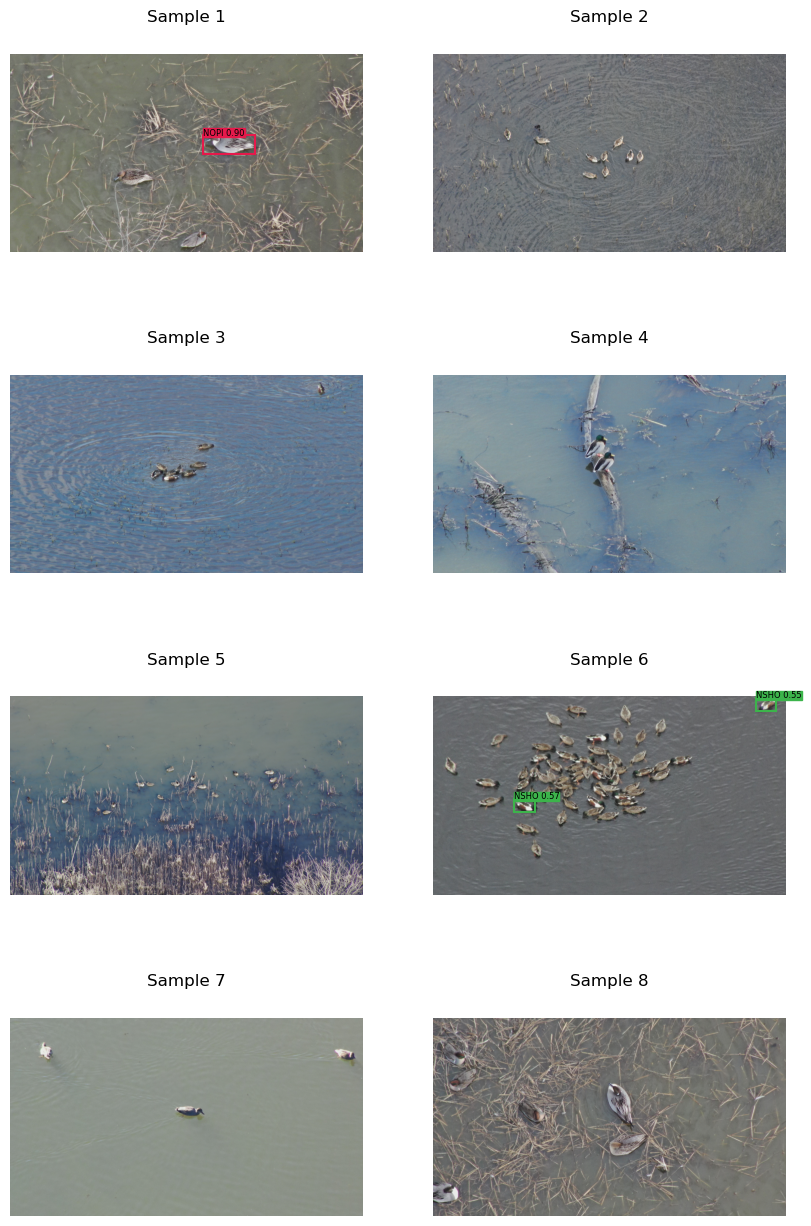

In [293]:
# Plot 8 samples from batch in a grid of subplots. 
plt.figure(figsize = (10, 16))
for i in range(8):
    ax = plt.subplot(4, 2, 1 + i)
    plot_predictions(images[i], predictions[i]['boxes'], predictions[i]['labels'], predictions[i]['scores'], ax = ax)
    plt.axis('off')
    plt.title(f"Sample {i + 1}")

plt.show()

##### Plot Best and Worst 3 Images in Test Dataset